**PROBLEM** - To classify the EEG signals into deception or truth using Short-Time Fourier Transform(STFT) and Convolution Neural Network(CNN).

**OVERVIEW**:

The problem and the code has been implemented in following steps:

**STEP1**- Annotations file pre-processing; it includes dropping all null values, updating the path of all the EEG.csv files and removing the outliers.

**STEP2**- Creating the data; it includes making a numpy ndimensional array of each EEG.csv file, removing non-relevent values, padding the data to minimun length(ie., 3000) and cleaning the data.

**STEP3**- Converting the EEG signals into Averaged Spectrogram images using Short-time Fourier Transform(STFT); it includes choosing correct value of hyperparameters(like Window Size, Number of FFT parameters, hop length etc).

**STEP4**- Making a 2D-CNN model and fine-tuning it.

**STEP5**- Splitting the dataset into Train Test split. Train the dataset.

**STEP6**- Evaluation of the Model, plotting Confusion Matrix and ROC curve to show the model's performance.

In [1]:
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

**Preprocessing the Annotations file**

In [2]:
df = pd.read_csv("/Users/nikhilrajput/Downloads/ML_DL/deception detection/BagOfLies/Annotations.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   eeg      201 non-null    object
 1   gaze     325 non-null    object
 2   image    325 non-null    object
 3   run      325 non-null    int64 
 4   truth    325 non-null    int64 
 5   usernum  325 non-null    int64 
 6   video    325 non-null    object
dtypes: int64(3), object(4)
memory usage: 17.9+ KB


In [4]:
df.isna().sum()

eeg        124
gaze         0
image        0
run          0
truth        0
usernum      0
video        0
dtype: int64

In [5]:
df = df.dropna()

In [6]:
df.isna().sum()

eeg        0
gaze       0
image      0
run        0
truth      0
usernum    0
video      0
dtype: int64

In [7]:
pathList = df["eeg"].tolist()
truthList = df["truth"].tolist()
idxList = df.index.tolist()

In [8]:
def removeDot(path):
    return path[1:]


In [9]:
lengthList = []
for i in range(len(idxList)):
    try:
        path = '/Users/nikhilrajput/Downloads/ML_DL/deception detection/BagOfLies' + removeDot(pathList[i])
        lengthList.append(len(pd.read_csv(path)))
    except Exception as e:
        continue


**Plot of file vs length**

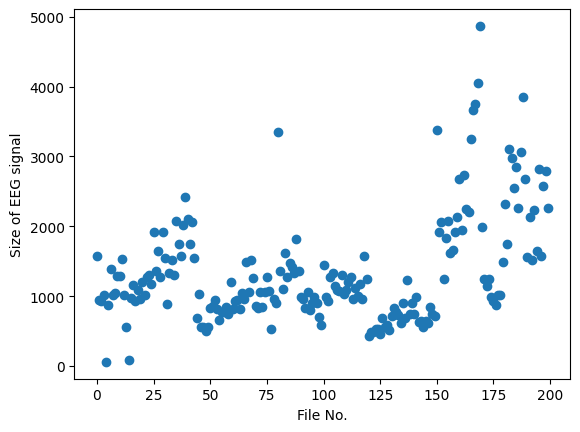

In [10]:
plt.scatter([i for i in range(len(idxList)-1)], lengthList)
plt.xlabel("File No.")
plt.ylabel("Size of EEG signal")
plt.show()

**REMOVING OUTLIERS**

In [11]:
lengthList = []
minl = 10000
newPathList = []
for i in range(len(idxList)):

    try:
        path = '/Users/nikhilrajput/Downloads/ML_DL/deception detection/BagOfLies' + removeDot(pathList[i])
        # print(path)
        l = len(pd.read_csv(path))
        if l < 100: 
            df = df.drop(idxList[i])
        elif l > 3000:
            lengthList.append(3000)
            newPathList.append(path)
        else: 
            lengthList.append(l)
            newPathList.append(path)
        
    except Exception as error:
        df = df.drop(idxList[i])

In [12]:
idxList = df.index.tolist()

In [13]:
len(idxList)

198

**After removing/rescaling outliers**

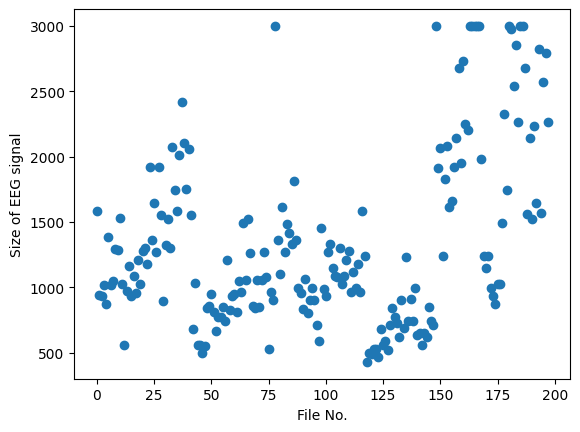

In [14]:
plt.scatter([i for i in range(len(idxList))], lengthList)
plt.xlabel("File No.")
plt.ylabel("Size of EEG signal")
plt.show()

In [15]:
np.mean(lengthList)

1334.060606060606

In [16]:
df = df.assign(**{"fullPath":newPathList})

In [17]:
df.to_csv("/Users/nikhilrajput/Downloads/ML_DL/deception detection/BagOfLies/finalAnn.csv")

In [18]:
df = pd.read_csv("/Users/nikhilrajput/Downloads/ML_DL/deception detection/BagOfLies/finalAnn.csv")

In [19]:
xdata = []
ydata = np.asarray(df["truth"].tolist())

In [20]:
EEGlist = pd.read_csv(df["fullPath"].tolist()[0]).columns[1:27].tolist()

In [21]:
np.count_nonzero(ydata)

108

SLICING AND PADDING

In [22]:
# def func(EEG):
#     l = len(EEG)
#     if l > 1334:
#         return np.array(EEG[:1334], dtype=int)
#     else:
#         rem = 1334-l
#         return np.array(EEG+[0 for i in range(rem)], dtype=int)

In [23]:
def func(EEG):
    l = len(EEG)
    if l > 3000:
        return np.array(EEG[:3000], dtype=int)
    else:
        rem = 3000-l
        return np.array(EEG+[0 for i in range(rem)], dtype=int)

CREATING THE DATA

In [24]:
def create_x_data():
    for i in newPathList:
        temp = pd.read_csv(i)
        temp.fillna(0,inplace=True)
        temp.replace("-",0, inplace=True)
        oneEEG = []
        for j in EEGlist:
            try:
                oneEEG.append(func(temp[j].tolist()))

            except:
                print(i)
                print(temp[j])
        xdata.append(np.transpose(np.array(oneEEG)))
    return np.asanyarray(xdata)

In [25]:
xdata = create_x_data()

In [26]:
xdata.shape

(198, 3000, 26)

NORMALIZING THE DATA

In [27]:
# scaler = StandardScaler()
# xdata_res = scaler.fit_transform(xdata.reshape(-1, xdata.shape[-1])).reshape(xdata.shape)
xdata_res = xdata


DFT CONVERSION

In [28]:


def generate_spectrograms(eeg_data, sr=64, n_fft=512, hop_length=16, win_length=64):
    """
    Generate spectrograms for each EEG channel and average them into a single spectrogram.
    
    Parameters:
    - eeg_data: NumPy array of shape (n_timepoints, n_channels)
    - sr: Sampling rate of the EEG data
    - n_fft: Number of FFT components
    - hop_length: Number of samples between successive frames
    - win_length: Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`.
    
    Returns:
    - avg_spectrogram: Averaged spectrogram across all channels, shape (freq_bins, time_steps)
    """
    n_timepoints, n_channels = eeg_data.shape
    spectrograms = []
    for channel in range(n_channels):
        # Compute the STFT/spectrogram for each channel
        S = np.abs(librosa.stft(eeg_data[:, channel].astype(np.float32), n_fft=n_fft, hop_length=hop_length, win_length=win_length))
        spectrograms.append(S)
    
    # Average the spectrograms across channels
    avg_spectrogram = np.mean(spectrograms, axis=0)
    
    return avg_spectrogram



**Displaying spectogram of one EEG file**

122
1
(257, 188)


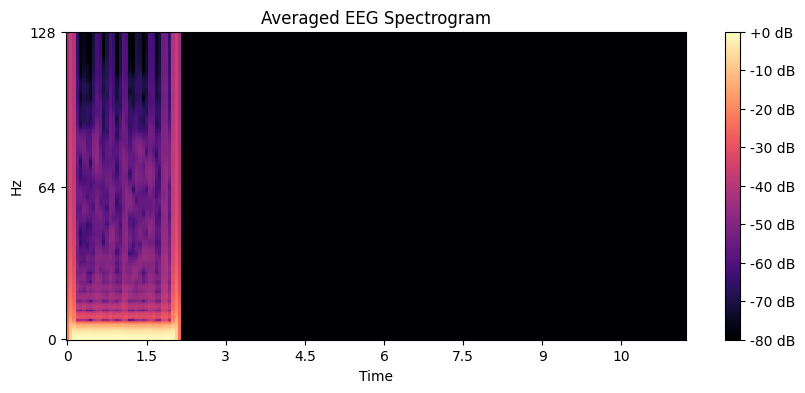

In [29]:
# file_no = rn.randint(1, 192)
file_no = 122
print(file_no)
print(ydata[file_no])
# Example EEG data of shape (1334, 13)
eeg_data = xdata_res[file_no]  # Replace this with your actual EEG data

# Generate averaged spectrogram
avg_spectrogram = generate_spectrograms(eeg_data)
print(avg_spectrogram.shape)

# Visualize the averaged spectrogram'

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(avg_spectrogram, ref=np.max), sr=256, hop_length=16, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Averaged EEG Spectrogram')
plt.show()


**Creating DFT data**

In [30]:
def create_dft_data():
    dft_data = []
    for i in range(xdata_res.shape[0]):
        dft_data.append(generate_spectrograms(xdata_res[i]))
    return np.asanyarray(dft_data)

In [31]:
dft_data = create_dft_data()

In [32]:
dft_data.shape

(198, 257, 188)

**Splitting the data into training and testing data**

In [33]:

xtrain, xtest, ytrain, ytest = train_test_split(dft_data, ydata, test_size=0.2, stratify=ydata, random_state=32)

In [34]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(158, 257, 188)
(158,)
(40, 257, 188)
(40,)


**CREATING 2D CNN MODEL**

In [35]:
import tensorflow as tf
from keras import layers, models
# from keras

In [36]:

def create_cnn_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layers with padding
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten layer to feed into dense layers
    model.add(layers.Flatten())
    
    # Dense layers
    model.add(layers.Dense(1024, activation='relu'))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax')) # Output layer with 2 neurons for binary classification
    
    return model

# Create the model
input_shape = xtrain.shape[1:]+ (1,)  # assuming grayscale images
model = create_cnn_model(input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 257, 188, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 94, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 94, 64)       18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 94, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 47, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 47, 128)       7

**Resizing the data**

In [37]:
xtrainm = xtrain.reshape(xtrain.shape + (1,))
xtestm = xtest.reshape(xtest.shape + (1,))
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)



**MODEL TRAINING**

In [38]:
model.fit(xtrainm, ytrain, batch_size=32, epochs=100, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 9s 2s/step - loss: 2405.3086 - accuracy: 0.5000 - val_loss: 1.2223 - val_accuracy: 0.3438
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 0.8320 - accuracy: 0.4603 - val_loss: 0.7706 - val_accuracy: 0.3125
Epoch 3/100
4/4 [==============================] - 9s 2s/step - loss: 0.7221 - accuracy: 0.4603 - val_loss: 0.8124 - val_accuracy: 0.3438
Epoch 4/100
4/4 [==============================] - 9s 2s/step - loss: 0.7379 - accuracy: 0.4286 - val_loss: 0.6444 - val_accuracy: 0.6562
Epoch 5/100
4/4 [==============================] - 9s 2s/step - loss: 0.6917 - accuracy: 0.5317 - val_loss: 0.6912 - val_accuracy: 0.4375
Epoch 6/100
4/4 [==============================] - 10s 2s/step - loss: 0.6998 - accuracy: 0.4762 - val_loss: 0.6610 - val_accuracy: 0.7188
Epoch 7/100
4/4 [==============================] - 10s 2s/step - loss: 0.6889 - accuracy: 0.5714 - val_loss: 0.6873 - val_accuracy: 0.5312
Epoch 8/100
4/4 [============

**MODEL TESTING AND EVALUATION**

In [39]:
ypred = model.predict(xtestm)

2/2 [==============================] - 1s 169ms/step


In [40]:
ytrue = np.argmax(ypred, axis=1)

In [41]:
ytrue

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [42]:
y_pred_probs = []
ytesttrue = []
for _ in range(len(ypred)):
    if ytrue[_] == 1:
        ytesttrue.append(ytest[_])
        y_pred_probs.append(max(ypred[_]))

In [43]:
ytest

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0])

In [44]:
np.count_nonzero(ytest)

22

**CONFUSION MATRIX**

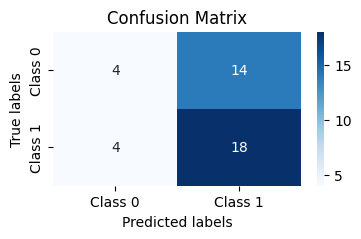

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred contains the predicted labels and y_true contains the true labels (0 or 1)
cm = confusion_matrix(ytest, ytrue)

# Define class labels
class_names = ['Class 0', 'Class 1']

# Plot confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


**Loss and Accuracy**

In [46]:
loss, accuracy = model.evaluate(xtestm, ytest)
print(f"Test Accuracy: {accuracy}")

2/2 [==============================] - 1s 158ms/step - loss: 0.6683 - accuracy: 0.5500
Test Accuracy: 0.550000011920929


**ROC Curve**

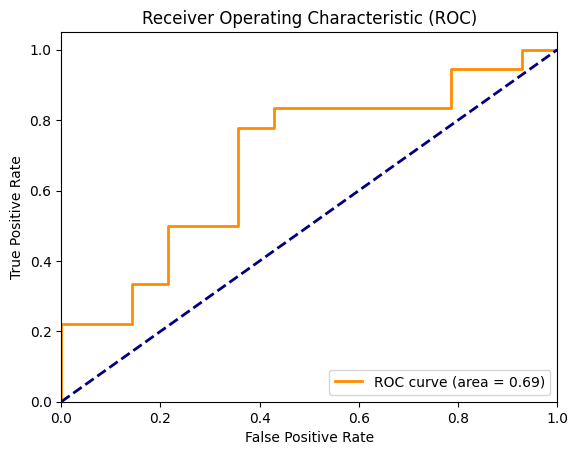

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_pred_probs is the predicted probabilities for the positive class
# and y_true contains the true labels (0 or 1)
fpr, tpr, thresholds = roc_curve(ytesttrue, y_pred_probs)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
